# Modelling a neural network
The point of this session is to become familiar with Keras and start doing some experiments

In [1]:
import numpy as np
# import pipeline as io
import keras
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install fitsio

    100% |████████████████████████████████| 4.8MB 1.2MB/s 
  Running setup.py bdist_wheel for fitsio ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/a1/de/35/ca1372d3267a2293bb079a444f3899c1cce0cac5c0191c8906
Successfully built fitsio


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/mqc-collab/')
import pipeline as io

----
Check on how to save the dataset to a HDF5 file 

In [0]:
import h5py
import os


from keras.layers import Input, Dense, Conv1D, Dropout, Flatten
from keras.activations import  softmax, relu, sigmoid
from keras.models import Model, Sequential
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from collections.abc import Iterable

def stringify_dict(metadata):
  
  for key in metadata:
    if isinstance(metadata[key], Iterable):
      for subkey in metadata[key]:
        metadata[key][subkey] = str(metadata[key][subkey])
    else:
      metadata[key] = str(metadata[key])
  
  return metadata

def performance_plots(filename, optiparams, histobject, testmetrics):
    
    loss = histobject.history['loss']
    val_loss = histobject.history['val_loss']
    binary_accuracy = histobject.history['binary_accuracy']
    val_binary_accuracy = histobject.history['val_binary_accuracy']
    
    plt.style.use('default')
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True,
                          sharey='row', figsize=(9,9))
    ax[0,0].plot(loss)
    ax[0,0].set_ylabel(r'Categorical cross-entropy loss')
    ax[0,1].plot(val_loss)
    ax[0,1].set_ylabel(r'Loss on validation data')
    ax[1,0].plot(binary_accuracy)
    ax[1,0].set_ylabel(r'Binary accuracy on training data')
    ax[1,1].plot(val_binary_accuracy)
    ax[1,1].set_ylabel(r'Binary accuracy on validation data')
    
    ax[1,0].set_xlabel(r'Epoch')
    ax[1,1].set_xlabel(r'Epoch')
    
    metadata = histobject.params
    metadata['test_metrics'] = testmetrics
    metadata['op_params'] = sgdparams
    
    metadata = stringify_dict(metadata)
    i = 0
    while os.path.exists('{}{:d}.png'.format(filename, i)):
      i += 1
    
    plt.savefig('{}{:d}.png'.format(filename, i), dpi=450, metadata=metadata)
    
    model_filename = '{}{:d}.h5'.format(filename, i)
    return model_filename
   

with h5py.File('/content/gdrive/My Drive/mqc-collab/dataset2K_433t.h5', 'r') as sb:
    og_shape = sb['fluxes'].shape
    data = np.array(sb['fluxes']).reshape((*og_shape, 1))
    labels = to_categorical(np.array(sb['classes']))
    
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20,
                                                       random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50,
                                                   random_state=42)

200/200 [==============================] - 0s 114us/step
test_loss: 0.2829028844833374
binary_accuracy: 0.9
CPU times: user 2min 45s, sys: 46.1 s, total: 3min 31s
Wall time: 3min 20s


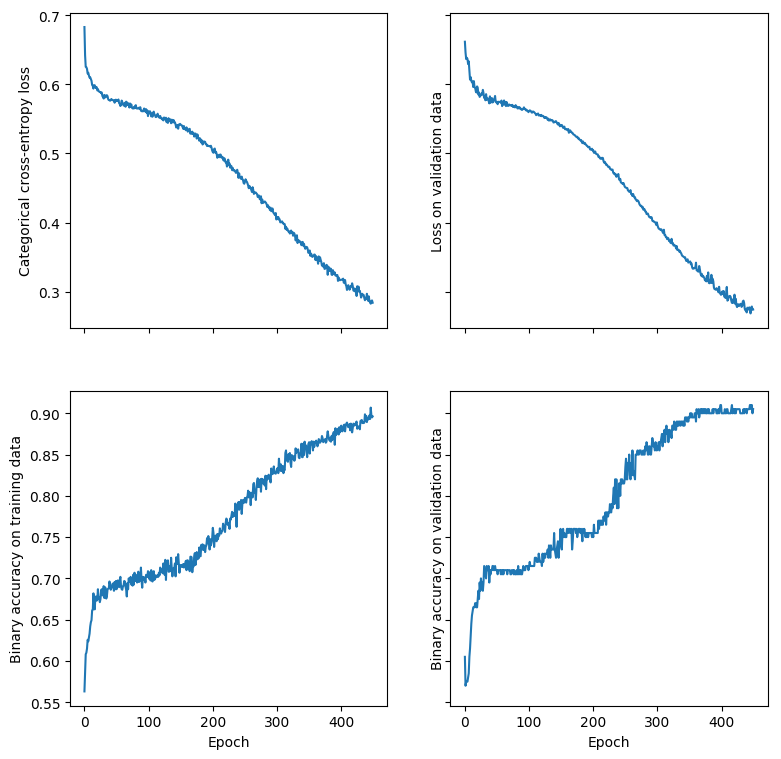

In [0]:
%%time

sgdparams = {'lr':0.01, 'momentum':0.9, 'nesterov':True, 'decay':0.01}
    
    
model = Sequential()
model.add(Conv1D(filters=100, kernel_size=10,
                 strides=2, activation='relu',
                input_shape=(433,1)))

model.add(Conv1D(filters=100, kernel_size=10, 
                 strides=2, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=10,
                 strides=2, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=10,
                 strides=2, activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(**sgdparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=450, batch_size=40, 
                     validation_data=(x_val, y_val), verbose=0)
metrics = model.evaluate(x_test, y_test, batch_size=40)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model4_run', sgdparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)

This is a good model., however it may not be an improvement over the first one I trained. Run 0 gave 93% accuracy but then,
Run 1 only 90%. 

 Now let's use a bigger dataset, 17749 stars and 17750 quasars. The stellar spectra were selected in order to have the most homogeneous sample possible. We randomly chose 1775 objects from each of the following spectral types: O, B, A, F, G, K, M, L,  Carbon Stars and White Dwarfs.
 

In [0]:
# Load the new dataset
with h5py.File('/content/gdrive/My Drive/mqc-collab/dataset35499_433t.h5', 'r') as sb:
    og_shape = sb['fluxes'].shape
    data = np.array(sb['fluxes']).reshape((*og_shape, 1))
    labels = to_categorical(np.array(sb['classes']))
    
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20,
                                                       random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50,
                                                   random_state=42)

In [27]:
# Check if everything turned out alright
print(x_train.shape)

nans = np.where(np.isnan(x_train))[0]
if nans.size > 0:
  print('Oh no, there are {} NaN values!! :C'.format(nans.size))

if np.any(np.isinf(x_train)):
  print('Oh no, there are Inf values!! :C')

nans
# Replace those nans with zeros (end eventual infs with large numbers):
# x_train = np.nan_to_num(x_train)
print('Number of spectra affected:', int(1299/433))

(28400, 433, 1)
Oh no, there are 1299 NaN values!! :C
Number of spectra affected: 3


To address this problem, we may run ``preprocess.py`` again with some fixes. On the ``dataset35499_433t.h5`` file all nan rows were removed

In [37]:
# Load the fixed dataset
with h5py.File('/content/gdrive/My Drive/mqc-collab/dataset35497_433t.h5', 'r') as sb:
    og_shape = sb['fluxes'].shape
    data = np.array(sb['fluxes']).reshape((*og_shape, 1))
    labels = to_categorical(np.array(sb['classes']))
    
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20,
                                                       random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50,
                                                   random_state=42)

# Check if everything turned out alright
print(x_train.shape)

nans = np.where(np.isnan(x_train))[0]
if nans.size > 0:
  print('Oh no, there are {} NaN values!! :C'.format(nans.size))

if np.any(np.isinf(x_train)):
  print('Oh no, there are Inf values!! :C')


(28397, 433, 1)


Train on 28397 samples, validate on 3550 samples
Epoch 1/25
28397/28397 [==============================] - 21s 737us/step - loss: 0.6925 - binary_accuracy: 0.5084 - val_loss: 0.6952 - val_binary_accuracy: 0.5000
Epoch 2/25
28397/28397 [==============================] - 20s 690us/step - loss: 0.6935 - binary_accuracy: 0.4980 - val_loss: 0.6937 - val_binary_accuracy: 0.5000
Epoch 3/25
28397/28397 [==============================] - 20s 690us/step - loss: 0.6933 - binary_accuracy: 0.5025 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 4/25
28397/28397 [==============================] - 20s 691us/step - loss: 0.6933 - binary_accuracy: 0.5004 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 5/25
28397/28397 [==============================] - 20s 689us/step - loss: 0.6932 - binary_accuracy: 0.4998 - val_loss: 0.6941 - val_binary_accuracy: 0.5000
Epoch 6/25
28397/28397 [==============================] - 20s 692us/step - loss: 0.6933 - binary_accuracy: 0.5000 - val_loss: 0.6932 - v

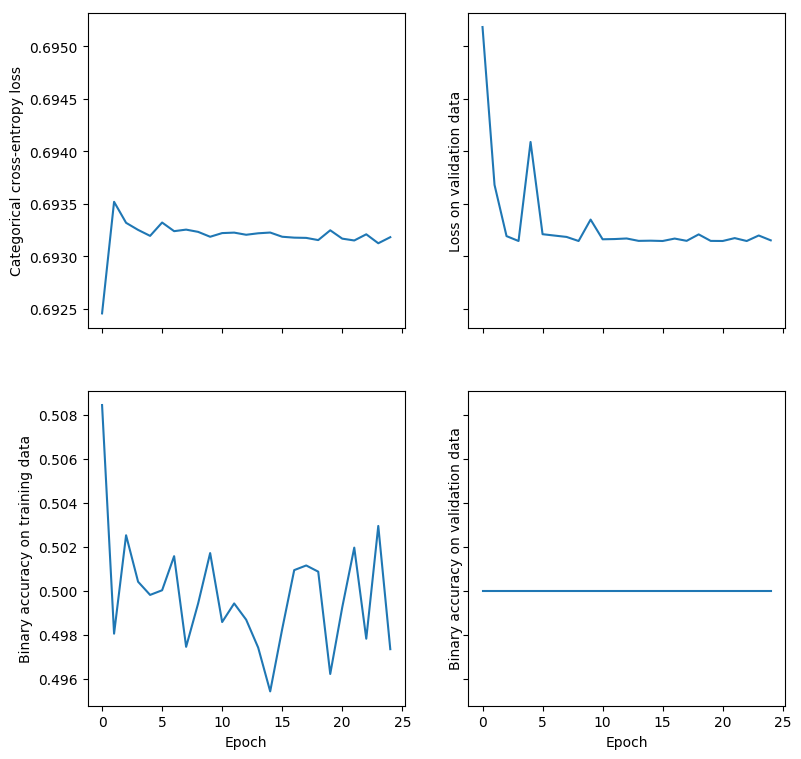

In [39]:
%%time

sgdparams = {'lr':0.2, 'momentum':0.9, 'nesterov':True, 'decay':0.01}
adamparams = dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4,
                  amsgrad=False)
    
model = Sequential()
model.add(Conv1D(filters=100, kernel_size=7,
                 strides=1, activation='relu',
                input_shape=(433,1)))
model.add(Conv1D(filters=100, kernel_size=9, 
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=11,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=13,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100,kernel_size=15,
                 strides=3, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(**sgdparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=25, batch_size=100, 
                     validation_data=(x_val, y_val), verbose=1)
metrics = model.evaluate(x_test, y_test, batch_size=40)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model6_run', adamparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)

Well... this is total crap, and after a whole lot of experiments I keep getting the same performance

Train on 28397 samples, validate on 3550 samples
Epoch 1/25
28397/28397 [==============================] - 21s 752us/step - loss: 0.5743 - binary_accuracy: 0.6893 - val_loss: 0.5542 - val_binary_accuracy: 0.7369
Epoch 2/25
28397/28397 [==============================] - 20s 708us/step - loss: 0.4798 - binary_accuracy: 0.7302 - val_loss: 0.3645 - val_binary_accuracy: 0.7997
Epoch 3/25
28397/28397 [==============================] - 20s 708us/step - loss: 0.2659 - binary_accuracy: 0.8875 - val_loss: 0.0928 - val_binary_accuracy: 0.9730
Epoch 4/25
28397/28397 [==============================] - 20s 712us/step - loss: 0.1248 - binary_accuracy: 0.9590 - val_loss: 0.0795 - val_binary_accuracy: 0.9769
Epoch 5/25
28397/28397 [==============================] - 20s 711us/step - loss: 0.1016 - binary_accuracy: 0.9666 - val_loss: 0.0684 - val_binary_accuracy: 0.9797
Epoch 6/25
28397/28397 [==============================] - 20s 710us/step - loss: 0.0896 - binary_accuracy: 0.9712 - val_loss: 0.0657 - v

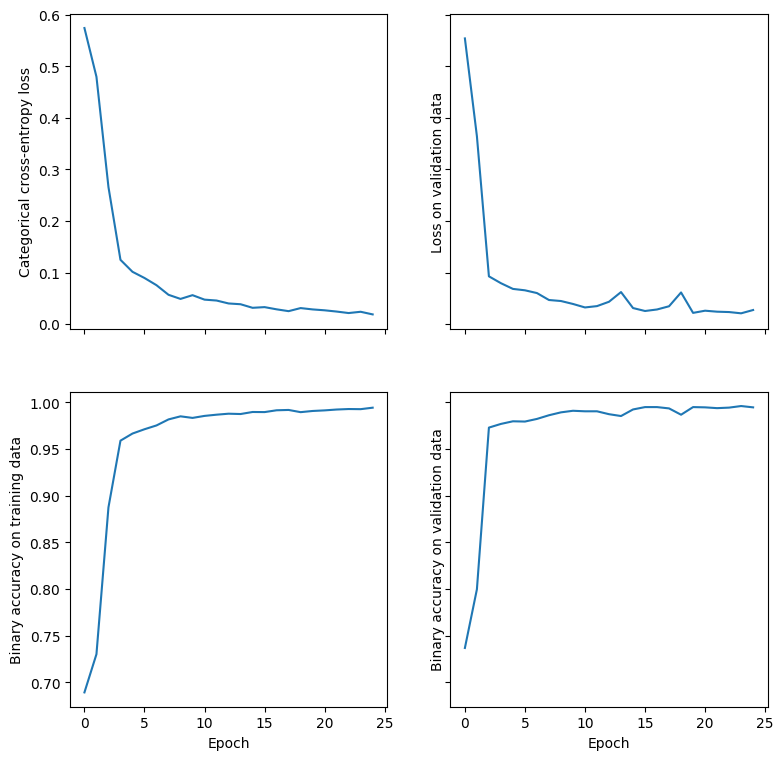

In [34]:
%%time

sgdparams = {'lr':0.2, 'momentum':0.9, 'nesterov':True, 'decay':0.01}
adamparams = dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0,
                  amsgrad=False)
    
model = Sequential()
model.add(Conv1D(filters=100, kernel_size=7,
                 strides=1, activation='relu',
                input_shape=(433,1)))
model.add(Conv1D(filters=100, kernel_size=9, 
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=11,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=13,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100,kernel_size=15,
                 strides=3, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(**adamparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=25, batch_size=100, 
                     validation_data=(x_val, y_val), verbose=1)
metrics = model.evaluate(x_test, y_test, batch_size=40)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model6_run', adamparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)

I expected that using a bigger dataset (35K spectra versus 2K), would immediately yield better results with the same architecture. After fiddling with the model and its parameters in Collab I was pretty disappointed because I cannot get the model to learn anything. It is stuck on loss ~0.6. Also the binary accuracy on the validation set is 0.4969 at the end of almost every epoch. Need to 1) tune those hyperparameters and/or 2) keep trying new architectures (deeper or shallower) 

---
#### Jan 25, 11:20 update
I changed the to Adam optimizer and the results were strikingly good! And I just used the default parameters of the Keras implementation. I cannot explain why the SDG was performing that bad. 

 Now let's add learning rate decay to see how well it does

Train on 28397 samples, validate on 3550 samples
Epoch 1/25
28397/28397 [==============================] - 22s 760us/step - loss: 0.5729 - binary_accuracy: 0.6882 - val_loss: 0.5071 - val_binary_accuracy: 0.7383
Epoch 2/25
28397/28397 [==============================] - 20s 715us/step - loss: 0.4913 - binary_accuracy: 0.7293 - val_loss: 0.3780 - val_binary_accuracy: 0.7713
Epoch 3/25
28397/28397 [==============================] - 20s 714us/step - loss: 0.3182 - binary_accuracy: 0.8399 - val_loss: 0.1351 - val_binary_accuracy: 0.9625
Epoch 4/25
28397/28397 [==============================] - 20s 717us/step - loss: 0.1409 - binary_accuracy: 0.9573 - val_loss: 0.0959 - val_binary_accuracy: 0.9727
Epoch 5/25
28397/28397 [==============================] - 20s 714us/step - loss: 0.0760 - binary_accuracy: 0.9759 - val_loss: 0.0542 - val_binary_accuracy: 0.9862
Epoch 6/25
28397/28397 [==============================] - 20s 716us/step - loss: 0.0623 - binary_accuracy: 0.9799 - val_loss: 0.0587 - v

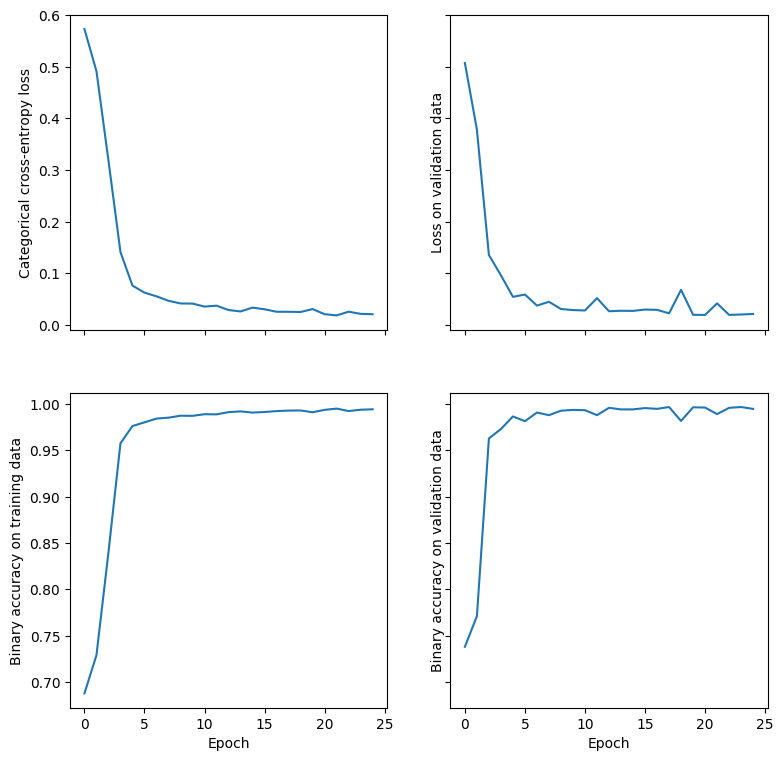

In [40]:
%%time

# sgdparams = {'lr':0.2, 'momentum':0.9, 'nesterov':True, 'decay':0.01}
adamparams = dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4,
                  amsgrad=False)
    
model = Sequential()
model.add(Conv1D(filters=100, kernel_size=7,
                 strides=1, activation='relu',
                input_shape=(433,1)))
model.add(Conv1D(filters=100, kernel_size=9, 
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=11,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=13,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100,kernel_size=15,
                 strides=3, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(**adamparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=25, batch_size=100, 
                     validation_data=(x_val, y_val), verbose=1)
metrics = model.evaluate(x_test, y_test, batch_size=40)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model6_run', adamparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)

Wow, a score of 99.5% !!  Can this be further improved? Maybe with 30 more epochs?

Train on 28397 samples, validate on 3550 samples
Epoch 1/30
28397/28397 [==============================] - 20s 709us/step - loss: 0.0170 - binary_accuracy: 0.9945 - val_loss: 0.0220 - val_binary_accuracy: 0.9952
Epoch 2/30
28397/28397 [==============================] - 20s 703us/step - loss: 0.0140 - binary_accuracy: 0.9951 - val_loss: 0.0205 - val_binary_accuracy: 0.9958
Epoch 3/30
28397/28397 [==============================] - 20s 709us/step - loss: 0.0192 - binary_accuracy: 0.9945 - val_loss: 0.0252 - val_binary_accuracy: 0.9949
Epoch 4/30
28397/28397 [==============================] - 20s 712us/step - loss: 0.0161 - binary_accuracy: 0.9952 - val_loss: 0.0193 - val_binary_accuracy: 0.9949
Epoch 5/30
28397/28397 [==============================] - 20s 714us/step - loss: 0.0113 - binary_accuracy: 0.9959 - val_loss: 0.0169 - val_binary_accuracy: 0.9963
Epoch 6/30
28397/28397 [==============================] - 20s 716us/step - loss: 0.0161 - binary_accuracy: 0.9951 - val_loss: 0.0213 - v

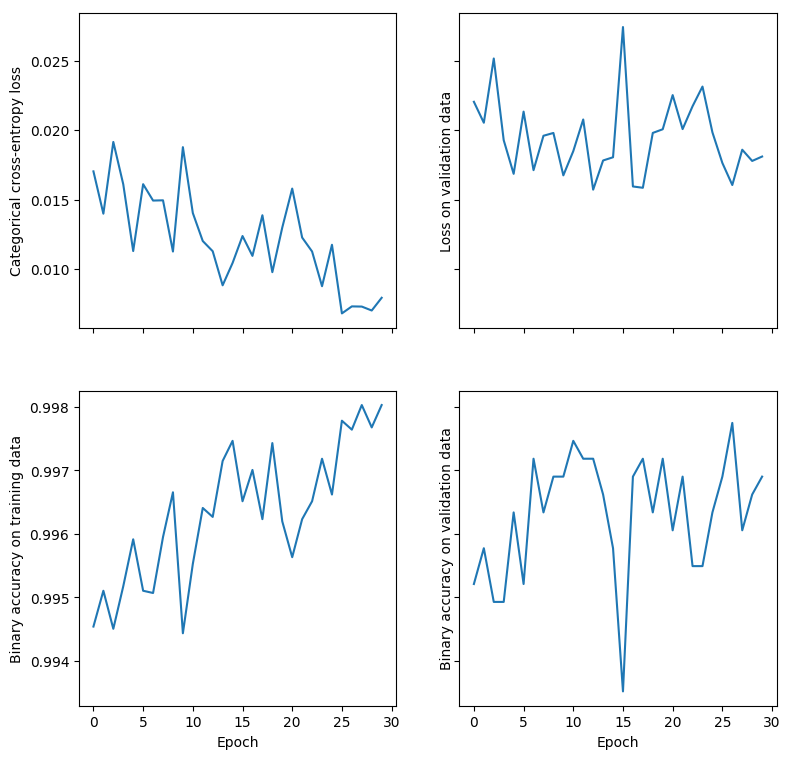

In [41]:

training = model.fit(x_train, y_train, epochs=30, batch_size=100, 
                     validation_data=(x_val, y_val), verbose=1)
metrics = model.evaluate(x_test, y_test, batch_size=40)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model6_run', adamparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)
print('Model saved to ' + model_filename)

Mmmm... It hardly makes any difference. However, on epoch 27 the accuracy on the validation set reached 0.9977, which is noticeably better than 0.995. Next, we try turning on ``amsgrad``

Train on 28397 samples, validate on 3550 samples
Epoch 1/25
28397/28397 [==============================] - 21s 731us/step - loss: 0.5249 - binary_accuracy: 0.6987 - val_loss: 0.3167 - val_binary_accuracy: 0.8766
Epoch 2/25
28397/28397 [==============================] - 19s 656us/step - loss: 0.2881 - binary_accuracy: 0.8718 - val_loss: 0.1237 - val_binary_accuracy: 0.9673
Epoch 3/25
28397/28397 [==============================] - 19s 655us/step - loss: 0.1061 - binary_accuracy: 0.9652 - val_loss: 0.0578 - val_binary_accuracy: 0.9808
Epoch 4/25
28397/28397 [==============================] - 19s 659us/step - loss: 0.0735 - binary_accuracy: 0.9777 - val_loss: 0.0553 - val_binary_accuracy: 0.9797
Epoch 5/25
28397/28397 [==============================] - 19s 659us/step - loss: 0.0594 - binary_accuracy: 0.9815 - val_loss: 0.0504 - val_binary_accuracy: 0.9859
Epoch 6/25
28397/28397 [==============================] - 19s 660us/step - loss: 0.0515 - binary_accuracy: 0.9838 - val_loss: 0.0345 - v

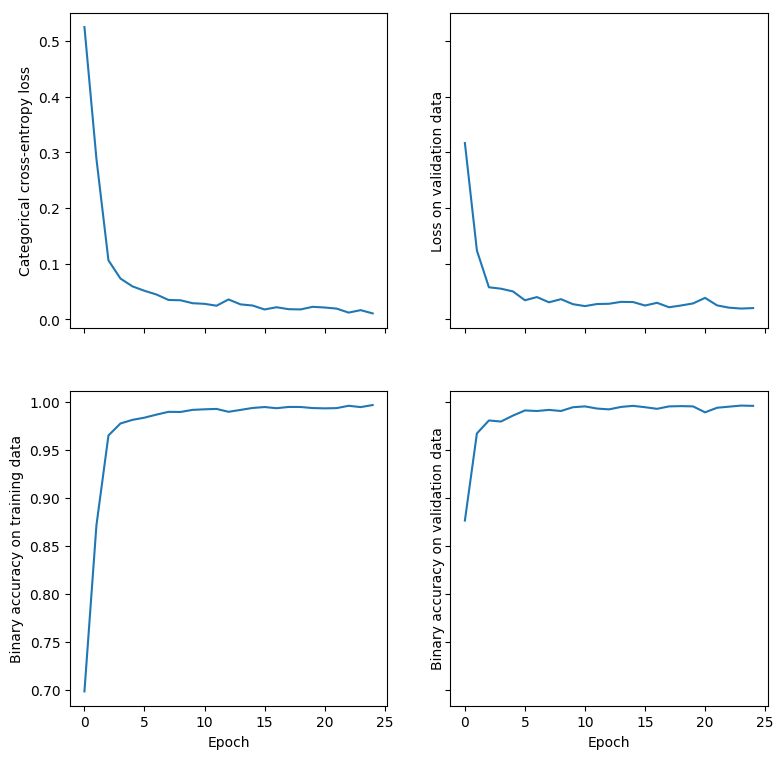

In [43]:
adamparams = dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4,
                  amsgrad=True)

model = Sequential()
model.add(Conv1D(filters=100, kernel_size=7,
                 strides=1, activation='relu',
                input_shape=(433,1)))
model.add(Conv1D(filters=100, kernel_size=9, 
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=11,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=13,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100,kernel_size=15,
                 strides=3, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(**adamparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=25, batch_size=150, 
                     validation_data=(x_val, y_val), verbose=1)
metrics = model.evaluate(x_test, y_test, batch_size=150)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model6_run', adamparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)
print('Model saved to ' + model_filename)

Learning went stupidly fast within the first 6 epochs, and after that the loss stayed pretty much the same. But is all this depth really needed, what happens if we return to our intial  architecture this time optimizing with Adam?

Train on 1600 samples, validate on 200 samples
Epoch 1/25
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6500 - binary_accuracy: 0.5712 - val_loss: 0.6258 - val_binary_accuracy: 0.6200
Epoch 2/25
1600/1600 [==============================] - 0s 126us/step - loss: 0.6170 - binary_accuracy: 0.6238 - val_loss: 0.5917 - val_binary_accuracy: 0.6500
Epoch 3/25
1600/1600 [==============================] - 0s 120us/step - loss: 0.6068 - binary_accuracy: 0.6469 - val_loss: 0.5758 - val_binary_accuracy: 0.6550
Epoch 4/25
1600/1600 [==============================] - 0s 122us/step - loss: 0.5926 - binary_accuracy: 0.6738 - val_loss: 0.5672 - val_binary_accuracy: 0.6950
Epoch 5/25
1600/1600 [==============================] - 0s 133us/step - loss: 0.5823 - binary_accuracy: 0.6838 - val_loss: 0.5706 - val_binary_accuracy: 0.7300
Epoch 6/25
1600/1600 [==============================] - 0s 129us/step - loss: 0.5744 - binary_accuracy: 0.6881 - val_loss: 0.5662 - val_binary_accuracy: 0.

TypeError: ignored

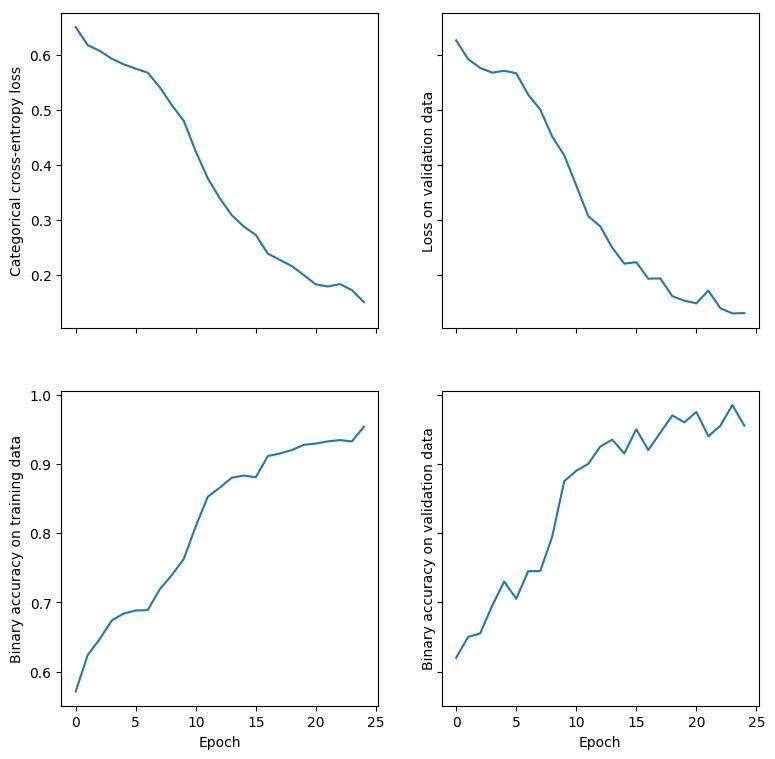

In [96]:
%%time

adamparams = dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4,
                  amsgrad=True)
    
model = Sequential()
model.add(Conv1D(filters=25, kernel_size=11,
                 strides=1, activation='relu',
                input_shape=(433,1)))

model.add(Conv1D(filters=25, kernel_size=10, 
                 strides=2, activation='relu'))
model.add(Conv1D(filters=15, kernel_size=9,
                 strides=2, activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(**adamparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=25, batch_size=100, 
                     validation_data=(x_val, y_val), verbose=1)
metrics = model.evaluate(x_test, y_test, batch_size=100)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model7_run', adamparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)
print('Model saved to ' + model_filename)

NOT BAD!!!! This is a much shallower net, it is impressive the result are on par with  the deep one. The bigger dataset is really paying off. Now let's make a few changes to the optimizer parameters to see if we can improve

Train on 28397 samples, validate on 3550 samples
Epoch 1/25
28397/28397 [==============================] - 5s 169us/step - loss: 0.5584 - binary_accuracy: 0.6825 - val_loss: 0.3816 - val_binary_accuracy: 0.8324
Epoch 2/25
28397/28397 [==============================] - 3s 117us/step - loss: 0.2948 - binary_accuracy: 0.8876 - val_loss: 0.1989 - val_binary_accuracy: 0.9375
Epoch 3/25
28397/28397 [==============================] - 3s 119us/step - loss: 0.1770 - binary_accuracy: 0.9373 - val_loss: 0.1208 - val_binary_accuracy: 0.9693
Epoch 4/25
28397/28397 [==============================] - 3s 116us/step - loss: 0.1350 - binary_accuracy: 0.9526 - val_loss: 0.0971 - val_binary_accuracy: 0.9761
Epoch 5/25
28397/28397 [==============================] - 3s 116us/step - loss: 0.1135 - binary_accuracy: 0.9614 - val_loss: 0.0934 - val_binary_accuracy: 0.9713
Epoch 6/25
28397/28397 [==============================] - 3s 115us/step - loss: 0.1005 - binary_accuracy: 0.9674 - val_loss: 0.0666 - val_bin

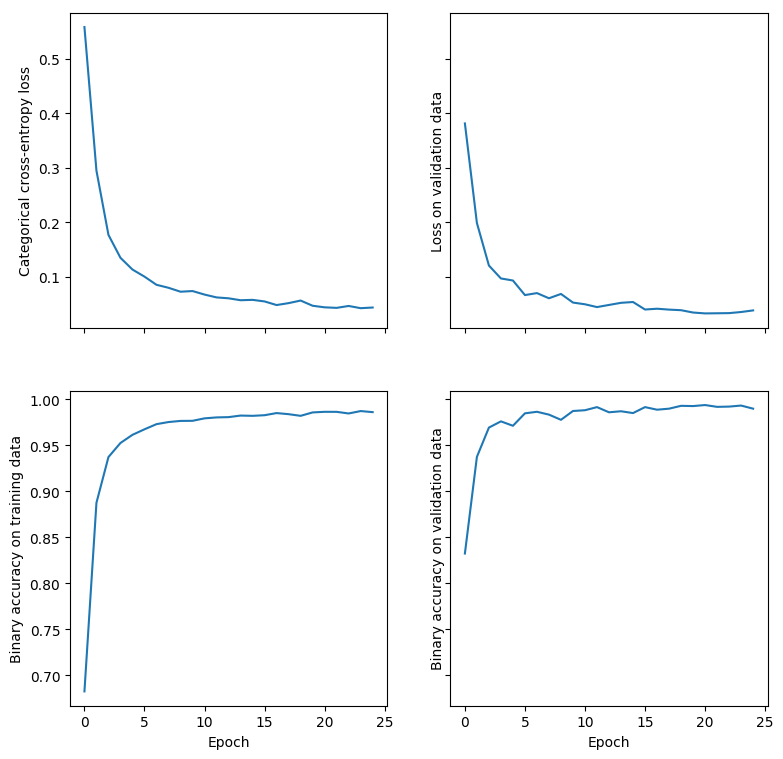

In [45]:
%%time

adamparams = dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-5,
                  amsgrad=False)
    
model = Sequential()
model.add(Conv1D(filters=25, kernel_size=11,
                 strides=1, activation='relu',
                input_shape=(433,1)))

model.add(Conv1D(filters=25, kernel_size=10, 
                 strides=2, activation='relu'))
model.add(Conv1D(filters=15, kernel_size=9,
                 strides=2, activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(**adamparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=25, batch_size=100, 
                     validation_data=(x_val, y_val), verbose=1)
metrics = model.evaluate(x_test, y_test, batch_size=100)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model7_run', adamparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)
print('Model saved to ' + model_filename)

Well, nope it's the same or worse. What if we remove decay?

Train on 28397 samples, validate on 3550 samples
Epoch 1/25
28397/28397 [==============================] - 5s 183us/step - loss: 0.5118 - binary_accuracy: 0.7214 - val_loss: 0.3125 - val_binary_accuracy: 0.9118
Epoch 2/25
28397/28397 [==============================] - 3s 117us/step - loss: 0.2614 - binary_accuracy: 0.9021 - val_loss: 0.1802 - val_binary_accuracy: 0.9634
Epoch 3/25
28397/28397 [==============================] - 3s 117us/step - loss: 0.1975 - binary_accuracy: 0.9263 - val_loss: 0.1468 - val_binary_accuracy: 0.9611
Epoch 4/25
28397/28397 [==============================] - 3s 118us/step - loss: 0.1573 - binary_accuracy: 0.9459 - val_loss: 0.1048 - val_binary_accuracy: 0.9755
Epoch 5/25
28397/28397 [==============================] - 3s 117us/step - loss: 0.1370 - binary_accuracy: 0.9545 - val_loss: 0.0972 - val_binary_accuracy: 0.9783
Epoch 6/25
28397/28397 [==============================] - 3s 118us/step - loss: 0.1270 - binary_accuracy: 0.9572 - val_loss: 0.0982 - val_bin

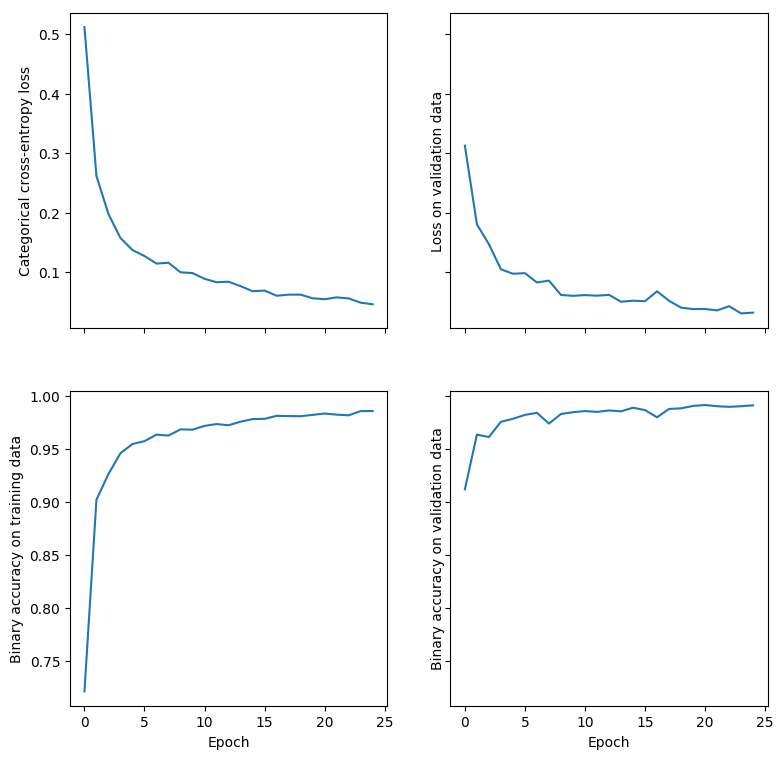

In [46]:
%%time

adamparams = dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0,
                  amsgrad=False)
    
model = Sequential()
model.add(Conv1D(filters=25, kernel_size=11,
                 strides=1, activation='relu',
                input_shape=(433,1)))

model.add(Conv1D(filters=25, kernel_size=10, 
                 strides=2, activation='relu'))
model.add(Conv1D(filters=15, kernel_size=9,
                 strides=2, activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(**adamparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=25, batch_size=100, 
                     validation_data=(x_val, y_val), verbose=1)
metrics = model.evaluate(x_test, y_test, batch_size=100)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model7_run', adamparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)
print('Model saved to ' + model_filename)

Alright, no improvement whatsoever. I am going to lunch now so I will leave the thing running for more epochs to see what happens

3550/3550 [==============================] - 0s 38us/step
test_loss: 0.010552676435573106
binary_accuracy: 0.9971831012779558
Model saved to /content/gdrive/My Drive/mqc-collab/plots/model7_run3.h5
CPU times: user 10min, sys: 1min 49s, total: 11min 50s
Wall time: 10min 27s


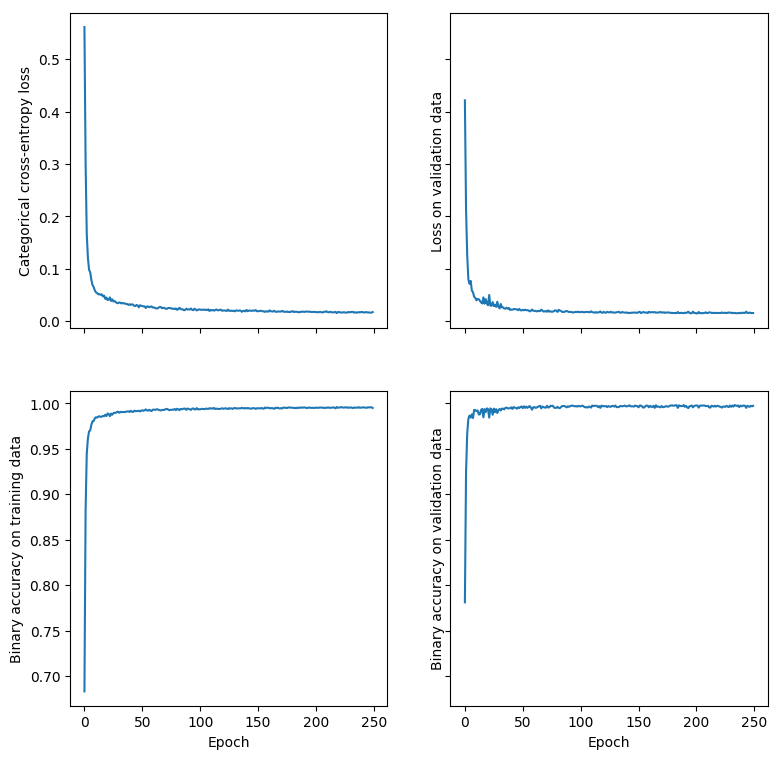

In [47]:
%%time

adamparams = dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4,
                  amsgrad=True)
    
model = Sequential()
model.add(Conv1D(filters=25, kernel_size=11,
                 strides=1, activation='relu',
                input_shape=(433,1)))

model.add(Conv1D(filters=25, kernel_size=10, 
                 strides=2, activation='relu'))
model.add(Conv1D(filters=15, kernel_size=9,
                 strides=2, activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(**adamparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=250, batch_size=120, 
                     validation_data=(x_val, y_val), verbose=0)
metrics = model.evaluate(x_test, y_test, batch_size=100)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model7_run', adamparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)
print('Model saved to ' + model_filename)

Nice! This time the score converged to 99.7%. It is interesting the wibbly section during slowdown, between epochs 25 and 50, on the valildation set. To a lesser extent these rapid oscillations are also present on the training loss and score plots.

---

Now I wish to write some wrapper functions to avoid copypasting the same code over and over again.

In [0]:
from keras.optimizers import Adam, SGD, Adamax
from keras.losses import categorical_crossentropy

def compile_train_test(model, data, optiparams, fitparams, evalparams, name,
                       optimizer=Adam, loss=categorical_crossentropy, 
                       metrics=['binary_accuracy']):
  
  train_data, test_data, val_data = data
  
  model.compile(loss=loss, optimizer=optimizer(**optiparams), 
                metrics=metrics)
  
  training = model.fit(*train_data,  **fitparams)
  
  score = model.evaluate(*test_data, **evalparams)
  model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/{}_run'.format(name),
                                     optiparams,training, score)
  print('test_loss: {}\nbinary_accuracy: {}'.format(score[0], score[1]))
  model.save(model_filename)
  print('Model saved to ' + model_filename)
  
  return model


def load_dataset(filename, train_size=0.8, test_split=0.5):
  
  with h5py.File(filename, 'r') as sb:
      og_shape = sb['fluxes'].shape
      data = np.array(sb['fluxes']).reshape((*og_shape, 1))
      labels = np.array(sb['classes'])
      if labels.shape[1] == 1:
        labels = to_categorical(labels)

  x_train, x_test, y_train, y_test = train_test_split(data,labels, 
                                                      test_size=1.0 - train_size,
                                                       random_state=42)
  
  x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50,
                                                   random_state=42)
  
  data = (x_train, y_train), (x_test, y_test), (x_val, y_val)
  return data

In the next one  I reduce  the learning rate decay factor to 1e-6, to see if I can make the slowdown less severe

In [0]:
def model_shallow7():
  model = Sequential()
  model.add(Conv1D(filters=25, kernel_size=11,
                 strides=1, activation='relu',
                input_shape=(433,1)))

  model.add(Conv1D(filters=25, kernel_size=10, 
                 strides=2, activation='relu'))
  model.add(Conv1D(filters=15, kernel_size=9,
                 strides=2, activation='relu'))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  
  return model

data = load_dataset('/content/gdrive/My Drive/mqc-collab/dataset35497_433t.h5')

optiparams=dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6,
                  amsgrad=True)

fitparams= dict(epochs=100, batch_size=120, validation_data=data[-1])

evalparams = dict(batch_size=100)

# trained_model  = compile_train_test(model_shallow7(), data, optiparams, fitparams, evalparams, 
#                     'model7')


  

In [89]:
def model_shallow7_multiclass():
  model = Sequential()
  model.add(Conv1D(filters=25, kernel_size=11,
                 strides=1, activation='relu',
                input_shape=(433,1)))

  model.add(Conv1D(filters=25, kernel_size=10, 
                 strides=2, activation='relu'))
  model.add(Conv1D(filters=15, kernel_size=9,
                 strides=2, activation='relu'))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(11, activation='softmax'))
  
  return model

data = load_dataset('/content/gdrive/My Drive/mqc-collab/dataset35498_433t_11c.h5')

optiparams=dict(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6,
                  amsgrad=True)

fitparams= dict(epochs=100, batch_size=120, validation_data=data[-1])

evalparams = dict(batch_size=100)

trained_model  = compile_train_test(model_shallow7_multiclass(), data, optiparams, fitparams, evalparams, 
                   'model7v2', metrics=['categorical_accuracy'])

Train on 28398 samples, validate on 3550 samples
Epoch 1/100
28398/28398 [==============================] - 6s 211us/step - loss: 1.4900 - categorical_accuracy: 0.5813 - val_loss: 1.2362 - val_categorical_accuracy: 0.6437
Epoch 2/100
28398/28398 [==============================] - 3s 112us/step - loss: 1.2591 - categorical_accuracy: 0.6382 - val_loss: 1.1520 - val_categorical_accuracy: 0.6642
Epoch 3/100
28398/28398 [==============================] - 3s 112us/step - loss: 1.1346 - categorical_accuracy: 0.6634 - val_loss: 0.9536 - val_categorical_accuracy: 0.6876
Epoch 4/100
28398/28398 [==============================] - 3s 112us/step - loss: 0.9020 - categorical_accuracy: 0.7212 - val_loss: 0.7344 - val_categorical_accuracy: 0.7530
Epoch 5/100
28398/28398 [==============================] - 3s 113us/step - loss: 0.7423 - categorical_accuracy: 0.7653 - val_loss: 0.6376 - val_categorical_accuracy: 0.7972
Epoch 6/100
28398/28398 [==============================] - 3s 113us/step - loss: 0.683

KeyError: ignored

In [0]:
from collections.abc import Iterable

metadata = {'params':{'caca':0, 'moco': 2323, 'pipi':119}, 'test': True}

for key in metadata:
  if isinstance(metadata[key], Iterable):
    for subkey in metadata[key]:
      metadata[key][subkey] = str(metadata[key][subkey])
  else:
    metadata[key] = str(metadata[key])

In [93]:
metadata

{'params': {'caca': '0', 'moco': '2323', 'pipi': '119'}, 'test': 'True'}